In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
A = np.random.randn(4,3)
B = np.sum(A, axis = 1, keepdims = True)
B.shape

(4, 1)

# Data Loading

In [0]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [0]:
plt.style.use("ggplot")
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
words = set(list(data['Word'].values)) #Vocabulary
words.add('PADword')
n_words = len(words)
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print(n_words,n_tags)

35179 17


# Data Preprocessing

In [0]:
class SentenceGetter(object):
  def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].
                                                   values.tolist(),s["Tag"].values.tolist())]
      self.grouped = self.data.groupby("Sentence #").apply(agg_func)
      self.sentences = [s for s in self.grouped]

  def get_next(self):
      try:
          s = self.grouped["Sentence: {}".format(self.n_sent)]
          self.n_sent += 1
          return s
      except:
          return None

In [0]:
getter = SentenceGetter(data)


[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [0]:
sent = getter.get_next()
print(sent)

In [0]:
sentences = getter.sentences
print(len(sentences))

47959


In [0]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


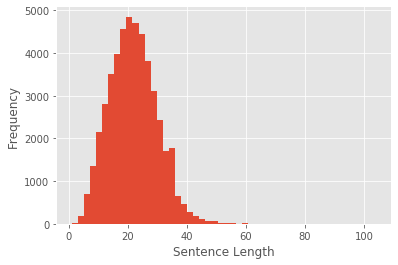

In [0]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences],bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [0]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
print(new_X[0])
sentences[0]

In [0]:
list(enumerate(tags))

In [0]:
tags2index

{'B-art': 0,
 'B-eve': 13,
 'B-geo': 16,
 'B-gpe': 8,
 'B-nat': 5,
 'B-org': 6,
 'B-per': 14,
 'B-tim': 7,
 'I-art': 15,
 'I-eve': 10,
 'I-geo': 3,
 'I-gpe': 2,
 'I-nat': 11,
 'I-org': 12,
 'I-per': 9,
 'I-tim': 4,
 'O': 1}

In [0]:
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y

Using TensorFlow backend.


array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 8,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  7, ...,  1,  1,  1],
       ...,
       [ 1, 16,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  6, 12, ...,  1,  1,  1]], dtype=int32)

# Model Building and Training

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [0]:
batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,
                                                           tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },signature="tokens",as_dict=True)["elmo"]

In [0]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 1024)     6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 1024)     6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

In [0]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 38816 samples, validate on 4320 samples
Epoch 1/3



38816/38816 [==============================] - 684s 18ms/step - loss: 0.0618 - acc: 0.9819 - val_loss: 0.0452 - val_acc: 0.9856
Epoch 2/3
38816/38816 [==============================] - 661s 17ms/step - loss: 0.0406 - acc: 0.9868 - val_loss: 0.0421 - val_acc: 0.9864
Epoch 3/3
38816/38816 [==============================] - 653s 17ms/step - loss: 0.0338 - acc: 0.9886 - val_loss: 0.0416 - val_acc: 0.9866


In [0]:
model.save_weights('bilstm_model.hdf5')

In [0]:
!pip install seqeval

# Model Evaluation

In [0]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

In [0]:
idx2tag = {i: w for w, i in tags2index.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])
print(classification_report(test_labels, pred_labels))

In [0]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

In [0]:
history.history

In [0]:
?(figsize=(12,12))
?(history.history["acc"],c = 'b')
?(history.history["val_acc"], c = 'g')
plt.show()

In [0]:
test_sentence = [["Hawking", "is", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]]

In [0]:
max_len = 50
X_test = [[w for w in s] for s in test_sentence]
new_X_test = []
for seq in X_test:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X_test.append(new_seq)
new_X_test

In [0]:
np.array(new_X_test,dtype='<U26')

In [0]:
np.array(X_te)[1]

# Inference

In [0]:
#model.load_weights('bilstm_model.hdf5')
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
p = ?(np.array(new_X_test*32,dtype='<U26'))[0]
p = ?(p, axis=-1)
print("{:15} {:5}".format("Word", "Pred"))
print("="*30)
for w, pred in zip(new_X_test[0], p):
    if w != "__PAD__":
        print("{:15}:{:5}".format(w, tags[pred]))